In [1]:
# Libraries use
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import time
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score
import xgboost as xgb
from xgboost import plot_importance
from sklearn.metrics import explained_variance_score, mean_squared_error, r2_score
from helper import create_dummy_df
import bokeh
import geopandas as gpd
from pyproj import CRS
import folium
from folium.plugins import MarkerCluster
from keras import models, layers, optimizers, regularizers
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor

%matplotlib inline

In [2]:
df = pd.read_csv('../NYC/data/prep_final.csv')
df.head()

,host_response_time,host_response_rate,host_is_superhost,host_listings_count,neighbourhood,neighbourhood_group,property_type,room_type,accommodates,bathrooms,...,child_friendly,parking,host_greeting,internet,long_term_stays,pets_allowed,private_entrance,self_check_in,days_since_first_review,days_since_last_review
0,a few days or more,0-49%,0.0,0.0,Washington Heights,Manhattan,Others,Private room,2,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,4+ years,1+ year
1,within a few hours,50-89%,0.0,6.0,Midtown,Manhattan,Apartment,Entire home/apt,2,1.0,...,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,4+ years,6-12 months
2,within an hour,90-99%,0.0,1.0,Clinton Hill,Brooklyn,Others,Entire home/apt,3,1.0,...,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,4+ years,0-2 weeks
3,unknown,unknown,0.0,1.0,Murray Hill,Manhattan,Apartment,Entire home/apt,2,1.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,4+ years,6-12 months
4,unknown,unknown,0.0,1.0,Bedford-Stuyvesant,Brooklyn,Apartment,Private room,2,1.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,4+ years,6-12 months


In [3]:
df_dum = pd.get_dummies(df)

In [4]:
def multi_collinearity_heatmap(df, figsize=(11,9)):
    
    """
    Creates a heatmap of correlations between features in the df. A figure size can optionally be set.
    """
    
    # Set the style of the visualization
    sns.set(style="white")

    # Create a covariance matrix
    corr = df.corr()

    # Generate a mask the size of our covariance matrix
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=figsize)

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5}, vmax=corr[corr != 1.0].max().max());

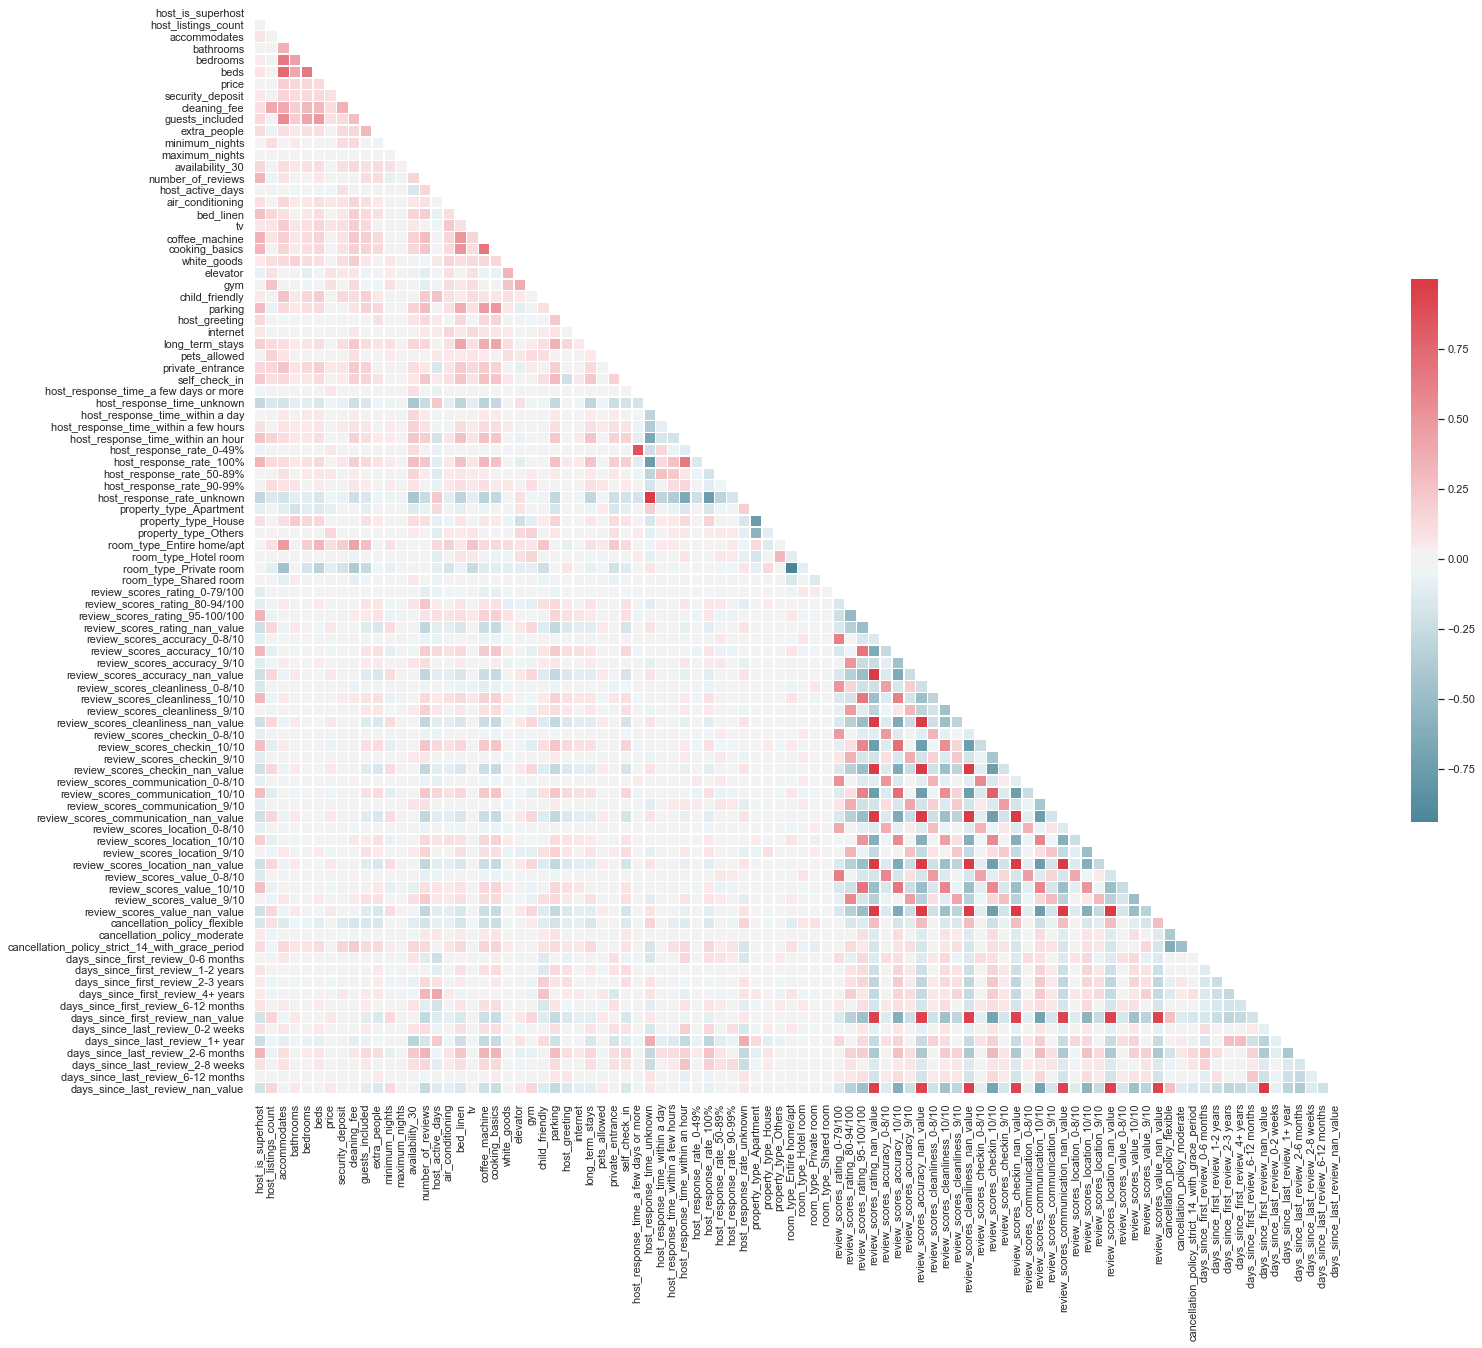

In [5]:
# Checking correlation between features
multi_collinearity_heatmap(df_dum.drop(list(df_dum.columns[df_dum.columns.str.startswith('neighbourhood')]), axis=1), figsize=(25,20))

In [6]:
drop_cols = ['beds', 'bedrooms','guests_included', 'host_response_rate_unknown','host_response_rate_0-49%','property_type_Apartment','room_type_Private room']
drop_cols.extend(list(df_dum.columns[df_dum.columns.str.endswith('value')]))
df_dum.drop(drop_cols, axis=1, inplace=True)

In [7]:
list(df_dum)

['host_is_superhost',
 'host_listings_count',
 'accommodates',
 'bathrooms',
 'price',
 'security_deposit',
 'cleaning_fee',
 'extra_people',
 'minimum_nights',
 'maximum_nights',
 'availability_30',
 'number_of_reviews',
 'host_active_days',
 'air_conditioning',
 'bed_linen',
 'tv',
 'coffee_machine',
 'cooking_basics',
 'white_goods',
 'elevator',
 'gym',
 'child_friendly',
 'parking',
 'host_greeting',
 'internet',
 'long_term_stays',
 'pets_allowed',
 'private_entrance',
 'self_check_in',
 'host_response_time_a few days or more',
 'host_response_time_unknown',
 'host_response_time_within a day',
 'host_response_time_within a few hours',
 'host_response_time_within an hour',
 'host_response_rate_100%',
 'host_response_rate_50-89%',
 'host_response_rate_90-99%',
 'neighbourhood_Allerton',
 'neighbourhood_Arden Heights',
 'neighbourhood_Arrochar',
 'neighbourhood_Arverne',
 'neighbourhood_Astoria',
 'neighbourhood_Bath Beach',
 'neighbourhood_Battery Park City',
 'neighbourhood_Bay Ri

In [8]:
#df_dum.to_csv('final_sample.csv', index=False ,encoding='utf-8')

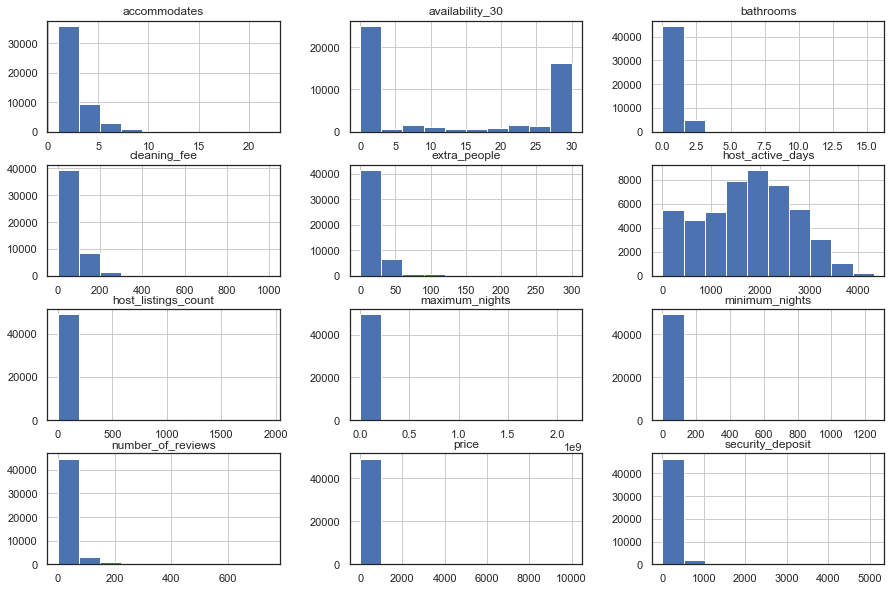

In [9]:
num_cols = ['host_listings_count',
            'accommodates',
            'bathrooms',
            'price',
            'security_deposit',
            'cleaning_fee',
            'extra_people',
            'minimum_nights',
            'maximum_nights',
            'availability_30',
            'number_of_reviews',
            'host_active_days'
            ]

df_dum[num_cols].hist(figsize=(15,10));

In [10]:
num_cols = [i for i in num_cols if i not in ['availability_30', 'host_active_days']]

for col in num_cols:
    df_dum[col] = df_dum[col].astype('float64').replace(0.0, 0.01) 
    df_dum[col] = np.log(df_dum[col])

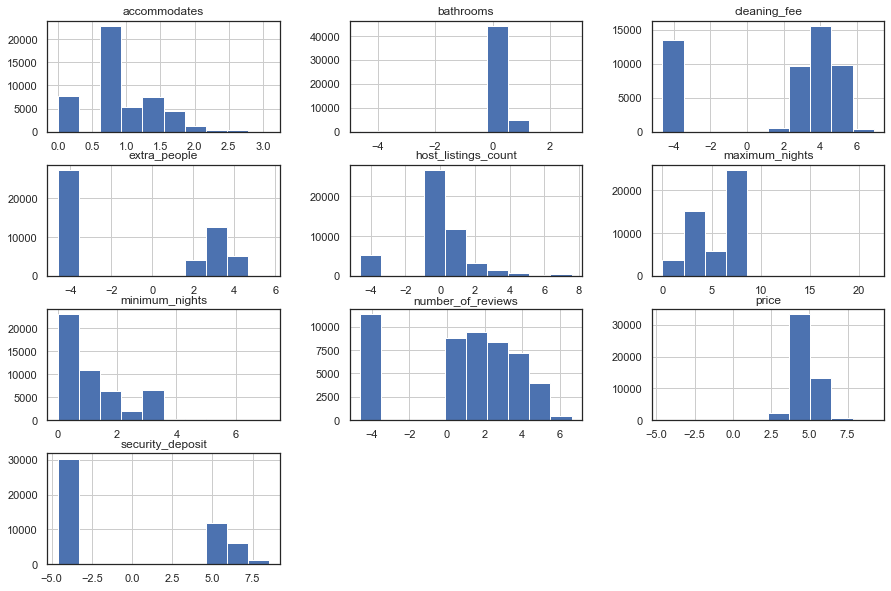

In [11]:
df_dum[num_cols].hist(figsize=(15,10));

In [12]:
# Split data into features and target 'price'
X = df_dum.drop('price', axis=1)
y = df_dum.price

#Scaling
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=list(X.columns))

# Fitting into KNN to select best features
best_features = SelectKBest(f_regression, k=5).fit(X, y)


In [13]:
# Feature scoring
df_scores = pd.DataFrame(best_features.scores_)
df_cols = pd.DataFrame(X.columns)
feature_scores = pd.concat([df_cols, df_scores], axis=1)
feature_scores.columns = ['Feature', 'Score']
print(feature_scores.nlargest(20,'Score'))

                           Feature         Score
265      room_type_Entire home/apt  20759.684070
2                     accommodates  18015.838094
260  neighbourhood_group_Manhattan   5357.252617
14                              tv   3349.027309
12                air_conditioning   2065.835430
17                     white_goods   1736.984481
18                        elevator   1730.664830
20                  child_friendly   1725.025460
19                             gym   1673.580975
261     neighbourhood_group_Queens   1652.406333
164          neighbourhood_Midtown   1611.346789
259   neighbourhood_group_Brooklyn   1340.023180
4                 security_deposit   1338.933438
5                     cleaning_fee   1150.716343
3                        bathrooms   1088.409967
26                private_entrance   1014.395895
267          room_type_Shared room   1009.030510
64          neighbourhood_Bushwick    938.868998
285    review_scores_location_9/10    808.464646
264           proper

In [14]:
df_dum.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49524 entries, 0 to 49523
Columns: 303 entries, host_is_superhost to days_since_last_review_6-12 months
dtypes: float64(28), int64(1), uint8(274)
memory usage: 23.9 MB
